# Causal discovery applied to coupled logistic maps

In [1]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline

# networks
import networkx as nx
from hierarchical_connectivities import hierarchical_connectivities # cantor algorithm
# flag: update c_nm in hierarchical_connectivities?

# causality tests
from statsmodels.tsa.stattools import grangercausalitytests 
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

# evaluation
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [12]:
def logistic(x0,a,tmax):
    '''
    Logistic map
    
    Parameters
    ----------
    x0 : float
         Initial value
    a : float
        bifurcation parameter
    tmax : int
            time step
    
    Returns
    -------
    x    : vector of length tmax, float
            
    """
    '''
    x = np.zeros(tmax)
    x[0] = x0
    for t in range(0,tmax-1):
        x[t+1] = a*x[t]*(1-x[t])
    return x


def logistic_map(z,a):
    '''
    univariate logistic map

    Parameters
    ----------
    z : float, 
        initial value.
    a : float, 
        bifurcation parameter.

    Returns
    -------
    f : float, 
        next time step.

    '''
    f = a*z*(1-z)
    return f


def logistic_map_N(z, C_ij, parameters):
    '''
    ring of logistic maps

    Parameters
    ----------
    z          :  vector of float, 
                  initializations of node values.
    C_ij       :  adjacency matrix, int.
    parameters :  dictionary of parameters
                  s = sigma, 
                  a = bifurcation parameter for logistic map,
                  T = time series length.
                  
                

    Returns
    -------
    z_T : matrix of shape (T, number of nodes).
        
    Source:
    Bonsen, A., Omelchenko, I., Zakharova, A. et al. 
    Chimera states in networks of logistic maps with hierarchical connectivities. 
    Eur. Phys. J. B 91, 65 (2018). 
    https://doi.org/10.1140/epjb/e2018-80630-y

    '''
    
    s = parameters['s']
    a = parameters['a']
    T = parameters['T']
    
    M = np.sum(C_ij)
    
    z_T = z.copy()
    t=1
    while t < T:
        f_zj = logistic_map(z, a) # vector
        z_next = []
        # coupling
        for i in np.arange(len(z)):
            f_zi = logistic_map(z[i], a) # number
            z_i = f_zi + s/M * (np.sum(C_ij * (f_zj - f_zi)))
            z_next.append(z_i)
        z_T = np.vstack((z_T, z_next))
        # update z's
        z = np.array(z_next)
        t+=1
    return z_T


def adj_from_corr(corr, m, use_threshold=False):
    '''
    generates adjacency matrix from matrix of correlation / causation values
    
    
    '''
    corr = pd.DataFrame(corr)
    # take absolute value
    corr = np.abs(corr)
    # ignore diagonal and upper triangle entries in corr matrix
    for i in range(corr.shape[0]):
        corr.iloc[i,i] = -np.inf
        for j in range(i, corr.shape[0]):
            corr.iloc[i,j] = -np.inf
    
    if use_threshold==True:
        threshold = m
    elif use_threshold==False:
        # get cutoff value for the top M correlation coefficients
        threshold = corr.melt().sort_values(by='value', ascending=False).reset_index(drop=True).value[m]

    # get adjacency matrix
    corr_adj = np.array(corr>=threshold)
    
    return corr_adj


def adj_from_pval(caus, m, use_threshold=False):
    
    caus = pd.DataFrame(caus)
    # ignore diagonal entries (self-loops)
    for i in range(caus.shape[0]):
        caus.iloc[i,i] = np.inf
    
    if use_threshold==True:
        threshold = m
    elif use_threshold==False:
        # get cutoff value for the m smallest p-values
        threshold = caus.melt().sort_values(by='value', ascending=True).reset_index(drop=True).value[m]

    # get adjacency matrix
    caus_adj = np.array(caus<threshold)
    
    return caus_adj


def pairwise_granger(data, maxlag):
    '''
    performs pairwise granger causality tests for variables in dataset up to max. lag
    
    Parameters
    ----------
    data   :   dataframe of shape (time, variables)
    maxlag :   int,
               maximum lag.
            
    Returns
    -------
    grang : 3d array of shape (variables, variables, maxlag), 
            p-values of granger causality tests.

    '''
    # prepare output array (rows & cols are variables, 3rd dimension are lags)
    grang = np.zeros([data.shape[1], 
                     data.shape[1],
                     maxlag])

    for i in range(0,data.shape[1]):
        for j in range(0,data.shape[1]):
            tempg = grangercausalitytests(data.iloc[:,[i,j]], maxlag=maxlag, verbose=False)
            # store the p-value result for the ssr f-test:
            out = [tempg[x][0]['ssr_ftest'][1] for x in range(1,maxlag+1)]
            grang[i,j,0:maxlag] = np.array(out)
    
    return grang


def color_edge_matches(G1,G2):
    '''
    return colors for edges of G2
    (blue if edge is in G1, red otherwise)
    '''
    colors=[]
    for e in G2.edges:
        if e in G1.edges:
            colors.append('blue')
        else:
            colors.append('red')
            
    return colors


def eval_metrics(y_true, y_pred):
    '''
    compute f1, precision, recall
    
    Parameters
    ----------
    y_true  :  vector of true links, 
    y_pred  :  vector of predicted links,           

    Returns
    -------
    out : dataframe of evaluation metrics
    
    '''
    
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    recall = recall_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    
    out = pd.DataFrame({'f1':f1, 'precision':precision, 'recall':recall}, index=[0])
    
    return(out)

Let us initially simulate the traditional logistic map em 1D.

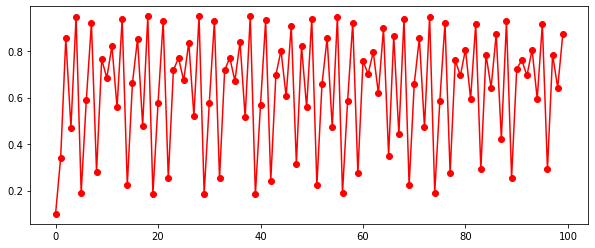

In [3]:
tmax = 100
x0 = 0.1
a = 3.8
x = logistic(x0,a,tmax)

plt.figure(figsize=(10,4))
plt.plot(np.arange(0,len(x)),x,'ro-')
plt.show(True)

Two-dimensional Poincaré plots:

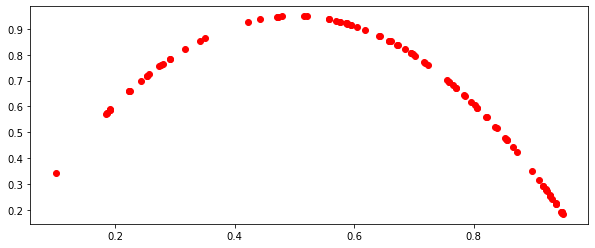

In [4]:
plt.figure(figsize=(10,4))

for t in range(0,tmax-1):
    plt.plot(x[t],x[t+1], 'ro')
plt.show(True)

### Networks

Let us adapt the logistic map to netowrks.

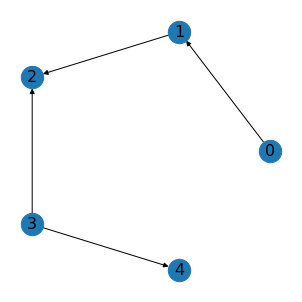

In [5]:
# Simple Networks
plt.figure(figsize=(4,4))

#N = 10
#av_degree = 1
#p = av_degree/(N-1)
#G = nx.gnp_random_graph(N, p, seed=None, directed=False)

#pos = nx.fruchterman_reingold_layout(G);
#plt.figure(figsize=(8,8));
#plt.axis("off");
#nx.draw_networkx_nodes(G, pos, node_size=300, node_color="black");
#nx.draw_networkx_edges(G, pos, alpha=0.500);
#nx.draw_networkx_labels(G, pos, font_color="white");
#plt.show();

edgelist=[(0,1),(1,2), (3,4),(3,2)]
G = nx.DiGraph(edgelist)
#G = nx.Graph(edgelist)

# get the adjacency matrix
G_adj = nx.to_numpy_matrix(G)
N = np.max(edgelist)

pos=nx.circular_layout(G)
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.show(True)



We generate time series for this network:

In [6]:
# generate time series directly from networkx object
tmax = 20
N = len(G.nodes)
x = np.zeros((N,tmax))
M = len(G.edges)
sigma = 3
a = 3.8
x[:,0] = np.random.uniform(0,1,N)
for t in range(0,tmax-1):
    for i in G.nodes:
        x[i,t+1] = a*x[i,t]*(1-x[i,t])
        for j in G.predecessors(i): #for directed networks
        #for j in G.neighbors(i): # for undirected networks
            x[i,t+1] = x[i,t+1] + (sigma/M)*(a*x[j,t]*(1-x[j,t])-a*x[i,t]*(1-x[i,t]))

print('Time series for each node:\n')
for i in G.nodes:
    #print('Node:', i,'Neig:', list(G.predecessors(i)))
    print('Node:', i, ':', x[i,:],'\n')

# save as dataframe
# rows are nodes, columns are time steps
data_networkx = pd.DataFrame(x.T)


Time series for each node:

Node: 0 : [0.61725405 0.89775565 0.34880367 0.86313075 0.44891703 0.94008401
 0.21403903 0.63926004 0.87630524 0.41189859 0.92050494 0.27806727
 0.76283429 0.68748892 0.81642204 0.56953296 0.93162764 0.24205081
 0.69715642 0.80229152] 

Node: 1 : [0.77607851 0.83840836 0.39030855 0.87341746 0.4417192  0.93933619
 0.2146638  0.63959912 0.87621541 0.41196281 0.92051568 0.27805869
 0.76283067 0.68749073 0.81642139 0.56953334 0.93162759 0.24205085
 0.69715644 0.80229151] 

Node: 2 : [0.09151605 0.89235377 0.7518613  0.88414519 0.65879235 0.85308313
 0.4293045  0.64178898 0.61133563 0.56884213 0.364317   0.20096221
 0.96279206 0.63872324 0.71515038 0.61252643 0.76279687 0.45092403
 0.47754275 0.8274598 ] 

Node: 3 : [0.73504644 0.74006205 0.7310068  0.74721625 0.71775967 0.76980676
 0.67337639 0.83577438 0.52157115 0.94823181 0.18653535 0.57661166
 0.92769648 0.25488773 0.7216959  0.76323352 0.68669083 0.81755683
 0.5667991  0.93304395] 

Node: 4 : [0.62289552 0.

Construct hierarchical network based on the cantor algorithm:

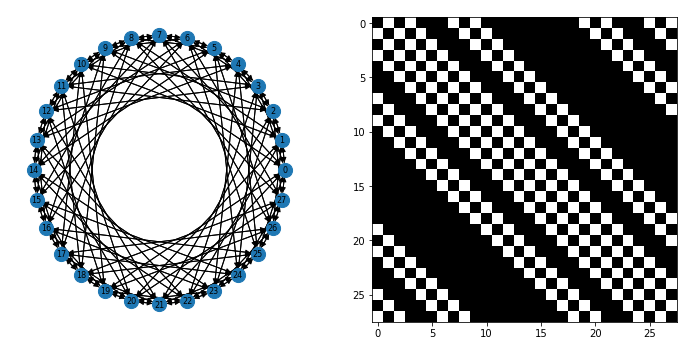

In [7]:
# Hierarchical network / Cantor algorithm

base = [1,0,1] # base pattern
m = 3
n = 3
# generate the adjacency matrix
C, c_nm = hierarchical_connectivities(base,n,m)

# networkx object
H = nx.from_numpy_matrix(C, create_using = nx.DiGraph())
pos_h=nx.circular_layout(H)

# plot network and adjacency matrix
plt.figure(figsize=(12,6))
plt.subplot(121); nx.draw(H, with_labels = True, node_size=200, font_size=8, pos = pos_h)
plt.subplot(122); plt.imshow(pd.DataFrame(C), cmap='gray')
plt.show(True)

Corresponding time series:

In [67]:
# initialize the nodes
z_0 = np.random.rand(C.shape[0])

parameters = {'a': 3.8,
             's': 0.7,
             'T':20}

# generate time series for hierarchical network
# nodes are columns, rows are time steps
Z = logistic_map_N(z=z_0, C_ij=C, parameters=parameters)

data_hierarchical = pd.DataFrame(data=Z)

### Correlation

In [68]:
corr_networkx = data_networkx.corr()
corr_hierarchical = data_hierarchical.corr()

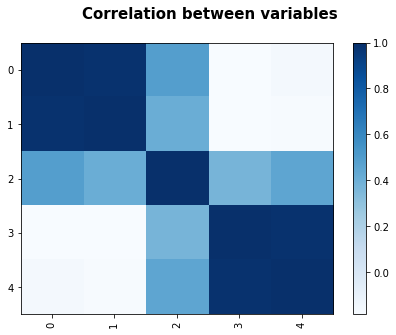

In [69]:
plt.figure(figsize=(7, 5))
plt.imshow(corr_networkx, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_networkx)), corr_networkx.columns, rotation='vertical')
plt.yticks(range(len(corr_networkx)), corr_networkx.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

In [70]:
# get adjacency matrix from correlations
corr_adj_networkx = adj_from_corr(corr_networkx, len(G.edges), use_threshold=False)


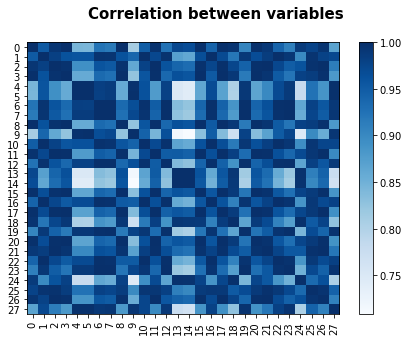

In [71]:
plt.figure(figsize=(7, 5))
plt.imshow(corr_hierarchical, cmap='Blues', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_hierarchical)), corr_hierarchical.columns, rotation='vertical')
plt.yticks(range(len(corr_hierarchical)), corr_hierarchical.columns);
plt.suptitle('Correlation between variables', fontsize=15, fontweight='bold')
plt.grid(False)
plt.show()

In [72]:
# get adjacency matrix from correlations
corr_adj_hierarchical = adj_from_corr(corr_hierarchical, len(H.edges), use_threshold=False)


### Granger Causality

In [73]:
maxlag=3
grang_networkx = pairwise_granger(data_networkx, maxlag)
grang_hierarchical = pairwise_granger(data_hierarchical, maxlag)

In [86]:
# create ajacency matrix
# for each variable pair, take most significant p-value
grang_adj_nx = adj_from_pval(grang_networkx.min(axis=2), len(G.edges), use_threshold=False)
grang_adj_h = adj_from_pval(grang_hierarchical.min(axis=2), len(H.edges), use_threshold=False)


### PCMCI - ParCorr

In [87]:
data = data_networkx

tau_max = 3

# prep data
dataframe = pp.DataFrame(data.values, datatime = data.index, var_names=data.columns)
# parcorr - run pcmci
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=0)

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
# correct p-values
q_matrix_nx = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')



In [88]:
data = data_hierarchical

tau_max = 3

# prep data
dataframe = pp.DataFrame(data.values, datatime = data.index, var_names=data.columns)
# parcorr - run pcmci
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(dataframe=dataframe, 
              cond_ind_test=parcorr,
              verbosity=0)

pcmci.verbosity = 0
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None)
# correct p-values
q_matrix_h = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')



/Users/kirstinroster/opt/anaconda3/lib/python3.7/site-packages/tigramite-4.2.0.2-py3.7-macosx-10.9-x86_64.egg/tigramite/data_processing.py:67: UserWarning: data.shape = (20, 28), is it of shape (observations, variables) ?
  " is it of shape (observations, variables) ?")


In [89]:
# create ajacency matrix
# for each variable pair, take most significant p-value
parcorr_adj_nx = adj_from_pval(q_matrix_nx.min(axis=2), len(G.edges), use_threshold=False)
parcorr_adj_h = adj_from_pval(q_matrix_h[:,:,1:].min(axis=2), len(H.edges), use_threshold=False)



### Evaluation

In [90]:
# set up nx objects

# from correlation adjacency matrix:
G2 = nx.from_numpy_matrix(corr_adj_networkx, create_using = nx.Graph())
H2 = nx.from_numpy_matrix(corr_adj_hierarchical, create_using = nx.Graph())
# from granger adjacency matrix:
G3 = nx.from_numpy_matrix(grang_adj_nx, create_using = nx.DiGraph())
H3 = nx.from_numpy_matrix(grang_adj_h, create_using = nx.DiGraph())
# from pcmci - parcorr adjacency matrix:
G4 = nx.from_numpy_matrix(parcorr_adj_nx, create_using = nx.DiGraph())
H4 = nx.from_numpy_matrix(parcorr_adj_h, create_using = nx.DiGraph())


In [91]:
# get the edge colors (blue=match, red=wrong)
colors_g2 = color_edge_matches(G,G2)
colors_g3 = color_edge_matches(G,G3)
colors_g4 = color_edge_matches(G,G4)

colors_h2 = color_edge_matches(H,H2)
colors_h3 = color_edge_matches(H,H3)
colors_h4 = color_edge_matches(H,H4)


Text(0.5, 0.98, 'NetworkX Graph')

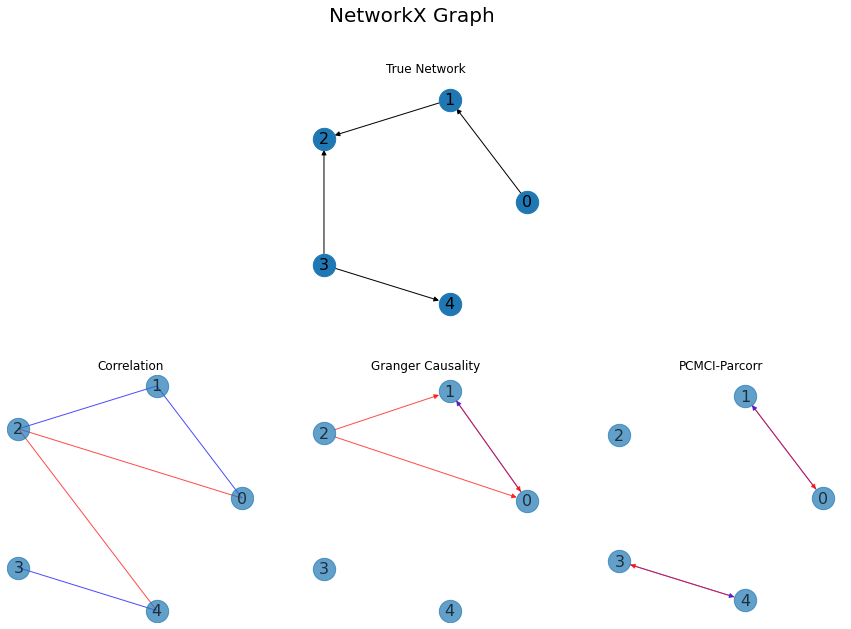

In [92]:
# plot all the graphs
plt.figure(figsize = (15,10))

# real (directed)
plt.subplot(232)
nx.draw(G, with_labels = True, node_size=500, font_size=16, pos = pos)
plt.title('True Network')

# correlation (undirected)
plt.subplot(234)
nx.draw(G2, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = colors_g2, alpha=0.7)
plt.title('Correlation')

# granger
plt.subplot(235)
nx.draw(G3, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = colors_g3, alpha=0.7)
plt.title('Granger Causality')

# pcmci - parcorr
plt.subplot(236)
nx.draw(G4, with_labels = True, node_size=500, font_size=16, pos = pos, edge_color = colors_g4, alpha=0.7)
plt.title('PCMCI-Parcorr')

plt.suptitle('NetworkX Graph', fontsize=20)

In [93]:
metrics = pd.concat([eval_metrics(y_true=np.array(G_adj.ravel())[0], y_pred=corr_adj_networkx.flatten().astype(float)),
                     eval_metrics(y_true=np.array(G_adj.ravel())[0], y_pred=parcorr_adj_nx.flatten().astype(float)),
                     eval_metrics(y_true=np.array(G_adj.ravel())[0], y_pred=grang_adj_nx.flatten().astype(float))
                     ], axis=0)
metrics.index = ['correlation', 'pcmci-parcorr','granger']

round(metrics,3)

,f1,precision,recall
correlation,0.00,0.00,0.00
pcmci-parcorr,0.50,0.50,0.50
granger,0.25,0.25,0.25


Text(0.5, 0.98, 'Hierarchical Graph')

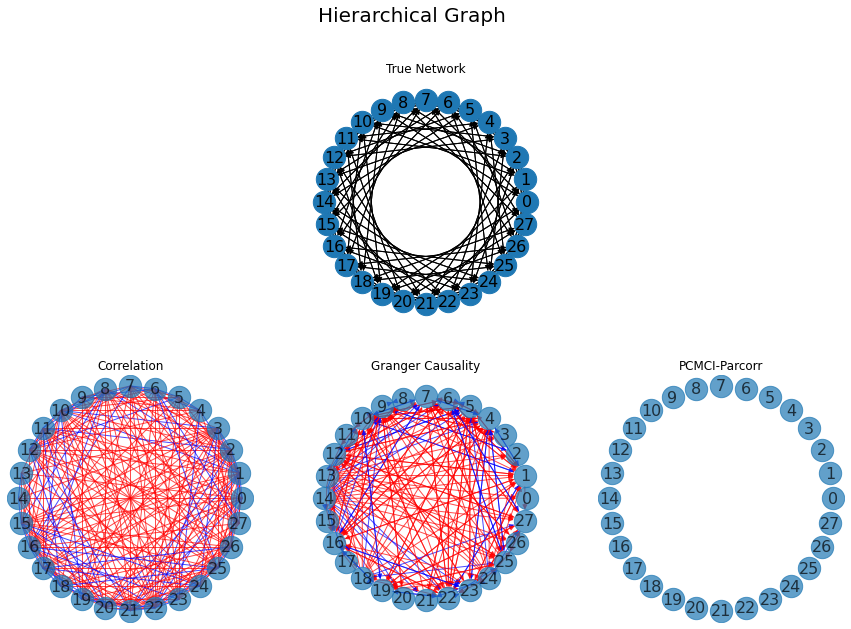

In [94]:
# plot all the graphs
plt.figure(figsize = (15,10))

# real (directed)
plt.subplot(232)
nx.draw(H, with_labels = True, node_size=500, font_size=16, pos = pos_h)
plt.title('True Network')

# correlation (undirected)
plt.subplot(234)
nx.draw(H2, with_labels = True, node_size=500, font_size=16, pos = pos_h, edge_color = colors_h2, alpha=0.7)
plt.title('Correlation')

# granger
plt.subplot(235)
nx.draw(H3, with_labels = True, node_size=500, font_size=16, pos = pos_h, edge_color = colors_h3, alpha=0.7)
plt.title('Granger Causality')

# pcmci - parcorr
plt.subplot(236)
nx.draw(H4, with_labels = True, node_size=500, font_size=16, pos = pos_h, edge_color = colors_h4, alpha=0.7)
plt.title('PCMCI-Parcorr')

plt.suptitle('Hierarchical Graph', fontsize=20)

In [95]:
metrics = pd.concat([eval_metrics(y_true=np.array(C.ravel()), y_pred=corr_adj_hierarchical.flatten().astype(float)),
                     eval_metrics(y_true=np.array(C.ravel()), y_pred=parcorr_adj_h.flatten().astype(float)),
                     eval_metrics(y_true=np.array(C.ravel()), y_pred=grang_adj_h.flatten().astype(float))
                     ], axis=0)
metrics.index = ['correlation', 'pcmci-parcorr','granger']

round(metrics,3)

/Users/kirstinroster/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1,precision,recall
correlation,0.285,0.284,0.286
pcmci-parcorr,0.000,0.000,0.000
granger,0.281,0.281,0.281
